# Exploratory Data Analysis (EDA) and Data Preprocessing - Task 1

## Task 1: Misogynistic Speech Detection

This task aims to classify phrases from song lyrics containing misogynistic speech. This is a binary classification task:

- **Misogynist (M)**: Lyrics contain hate speech or disdain directed at women or perpetuate harmful gender stereotypes that promote subordination or objectification of women.
- **Not Misogynist (NM)**: Lyrics do not include hate speech or disdain against women. They may address themes related to women without perpetuating stereotypes or negative attitudes.

### Example:

- `ID_Track1, "M"` this song is defined as misogynistic

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
import spacy
import nlpaug.augmenter.word as naw
import torch
import scattertext as st

from wordcloud import WordCloud
from collections import Counter
from utils import *


In [ ]:
SEED = 42
SUBTASK1_PATH = 'new_data\subtask1'

In [4]:
full_data = pd.read_csv(os.path.join(SUBTASK1_PATH, 'subtask1_train_rev002.csv'), encoding='utf-8')

full_data.set_index('id', inplace=True)
full_data

,lyrics,label
id,,
T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",NM
T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...",M
T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",NM
T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...",M
T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...",M
...,...,...
T1_TRAIN_2100,"\n[Letra de ""Tal Vez""]\n\n[Verso 1]\nTal vez s...",NM
T1_TRAIN_2101,"ebra, te muerde los pies\nÍbamos a la molienda...",NM
T1_TRAIN_2102,"\nTe amo, aunque a veces te maldiga\nAunque ju...",NM


### EDA Part 1 - Raw data

In [8]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2104 entries, T1_TRAIN_0001 to T1_TRAIN_2104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  2104 non-null   object
 1   label   2104 non-null   object
dtypes: object(2)
memory usage: 113.9+ KB


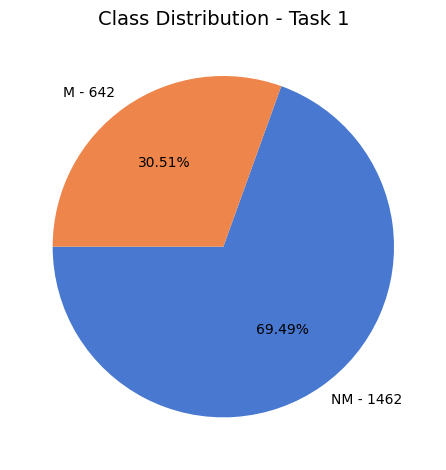

In [9]:
label_counts = full_data['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values
total = sizes.sum()
percentages = [f'{label} - {count}' for label, count in zip(labels, sizes)]

plt.pie(sizes, labels=percentages, autopct='%1.2f%%', startangle=180, colors=sns.color_palette('muted')) # , colors=sns.color_palette('pastel')
plt.title('Class Distribution - Task 1', fontsize=14)
plt.tight_layout()
plt.show()

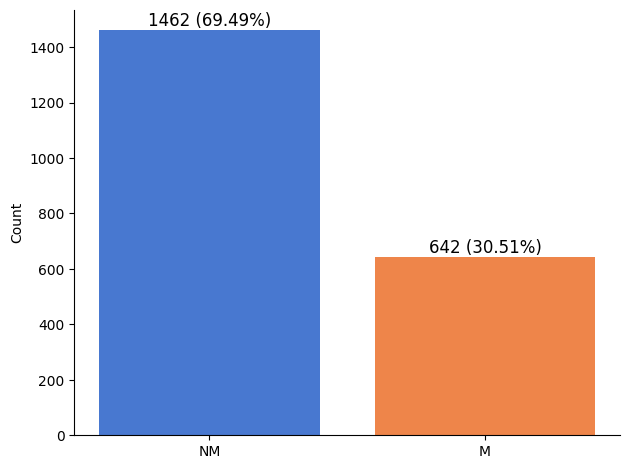

In [10]:
label_counts = full_data['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values
total = sizes.sum()
percentages = [f'{count} ({count/total:.2%})' for label, count in zip(labels, sizes)]

colors = sns.color_palette('muted')

bars = plt.bar(labels, sizes, color=colors)

# Percentage above bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, pct, ha='center', va='bottom', fontsize=12)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title('Class Distribution - Task 1', fontsize=14)
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#### Character Length Distribution Analysis

In [11]:
stats = pd.DataFrame(index=full_data.index)

stats['label'] = full_data['label']
stats['char_length'] = full_data['lyrics'].apply(len)
stats['word_count'] = full_data['lyrics'].apply(lambda x: len(re.findall(r'\w+', x)))
stats.describe()

,char_length,word_count
count,2104.000000,2104.000000
mean,1651.096483,320.562262
std,1062.163728,206.040112
min,69.000000,10.000000
25%,957.750000,186.000000
50%,1350.000000,261.000000
75%,2072.250000,402.250000
max,12950.000000,2495.000000


In [12]:
stats.groupby('label')[['char_length', 'word_count']].mean()

,char_length,word_count
label,,
M,2306.342679,448.490654
NM,1363.361833,264.385773


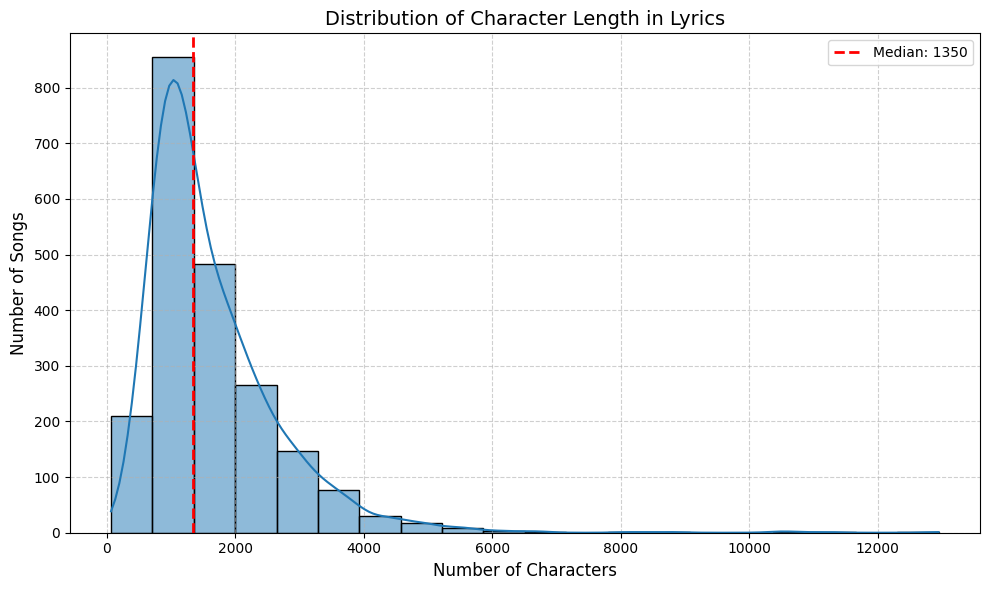

In [13]:
median_val_char = stats['char_length'].median()

plt.figure(figsize=(10, 6))
sns.histplot(stats['char_length'], bins=20, kde=True, edgecolor='black')
plt.axvline(median_val_char, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val_char:.0f}')
plt.title('Distribution of Character Length in Lyrics', fontsize=14)
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_30592\2156366255.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x='label', y='char_length', hue='label', data=stats, legend=False, palette=sns.color_palette('muted')) # , palette='pastel'


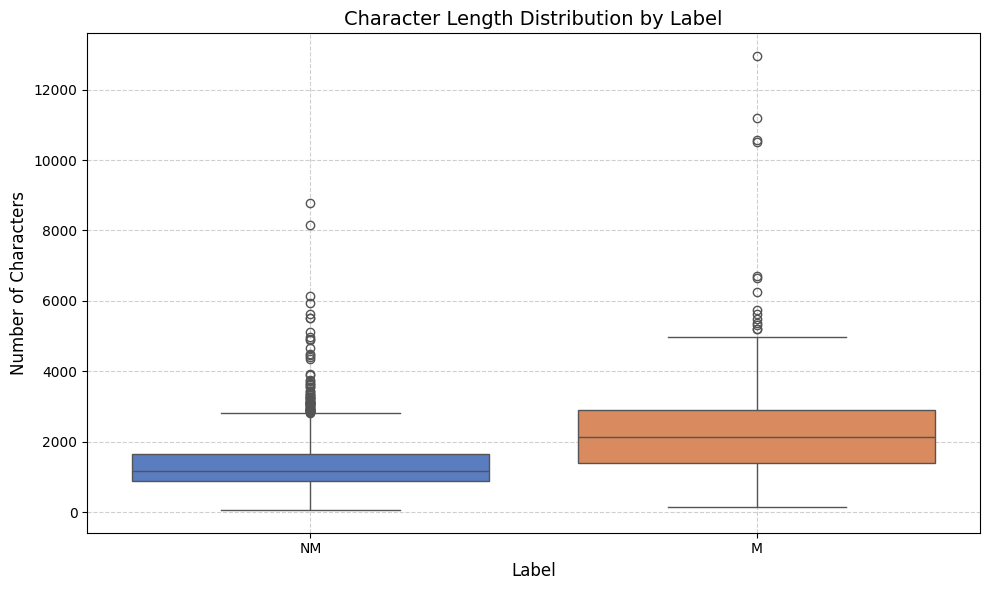

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='char_length', hue='label', data=stats, legend=False, palette=sns.color_palette('muted')) # , palette='pastel'
plt.title('Character Length Distribution by Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Characters', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Word Length Distribution Analysis

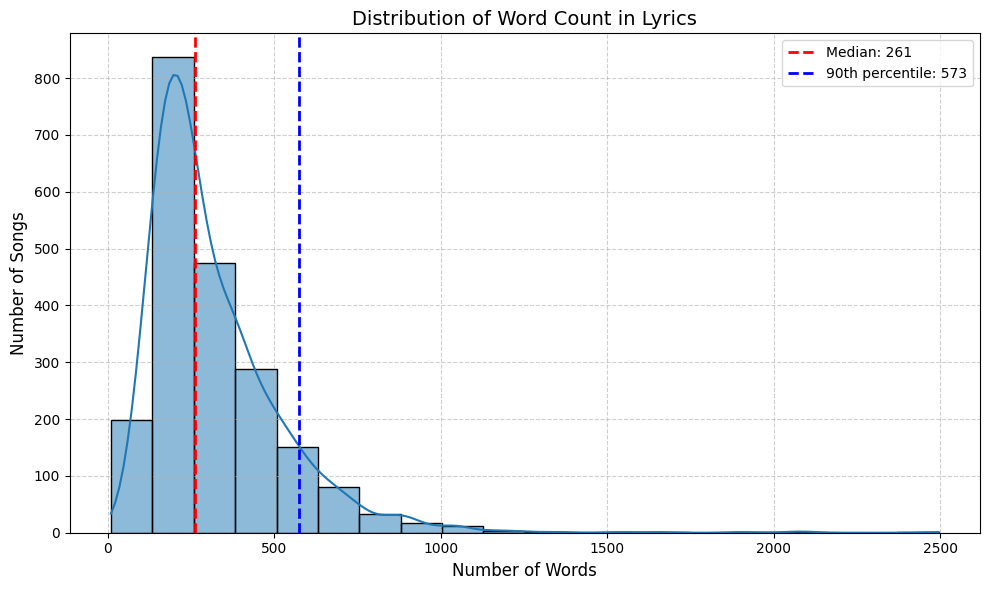

In [15]:
# Median and 90th percentile for word count
median_val_word = stats['word_count'].median()
p90_val_word = np.percentile(stats['word_count'], 90)

plt.figure(figsize=(10, 6))
sns.histplot(stats['word_count'], bins=20, kde=True, edgecolor='black')

# Median line
plt.axvline(median_val_word,
            color='red', linestyle='--', linewidth=2,
            label=f'Median: {median_val_word:.0f}')

# 90th percentile line
plt.axvline(p90_val_word,
            color='blue', linestyle='--', linewidth=2,
            label=f'90th percentile: {p90_val_word:.0f}')

plt.title('Distribution of Word Count in Lyrics', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_30592\4272455254.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x='label', y='word_count', hue='label', data=stats, dodge=False, palette=sns.color_palette('muted'))


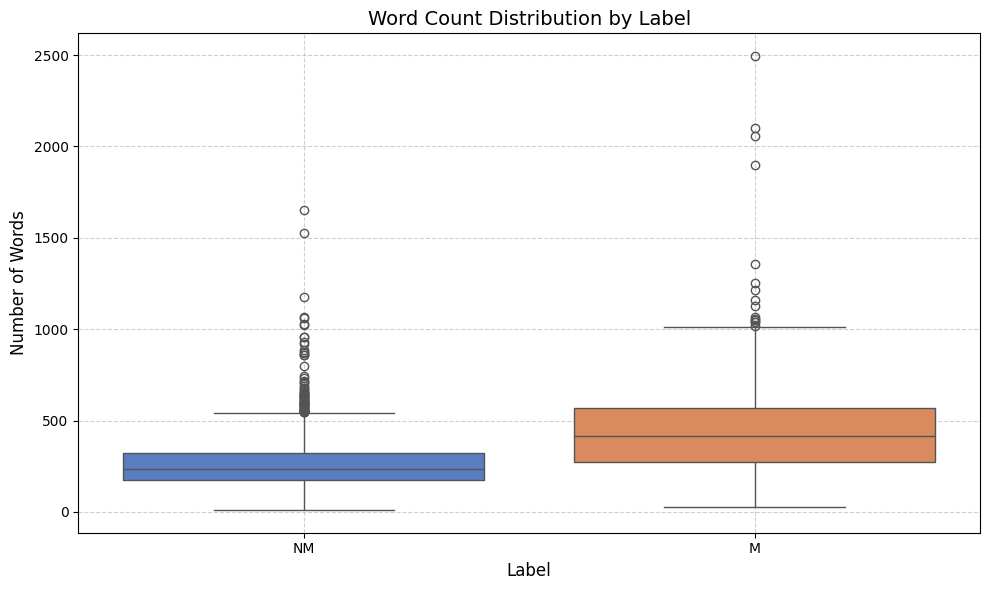

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', hue='label', data=stats, dodge=False, palette=sns.color_palette('muted'))
plt.title('Word Count Distribution by Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Data Preparation

In [17]:
language = 'spa'
model_type = 'ml'
stemming = False
lemmatization = False
remove_duplicates = True
cased = False # Keep cased for DL models
return_str = True

file_name = f"subtask1_train_clean_lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}_rev2.csv"
file_path = os.path.join(SUBTASK1_PATH, file_name)
vocabulary = 'lyrics'

# Check if file exists, otherwise preprocess and save
if os.path.exists(file_path):
    full_data = pd.read_csv(file_path, encoding='utf-8', index_col='id')
    print(f"Loaded cached preprocessed file: {file_path}")
else:
    full_data['lyrics_clean'] = full_data[vocabulary].apply(
        lambda x: text_preprocess(
            x,
            lang=language,
            model_type=model_type,
            stem=stemming,
            lemmatize=lemmatization,
            remove_duplicates=remove_duplicates,
            cased=cased,
            return_str=return_str
        )
    )
    full_data.to_csv(file_path, encoding='utf-8', index=True)
    print(f"Saved cleaned data to: {file_path}")

Loaded cached preprocessed file: new_data\subtask1\subtask1_train_clean_lang_spa_model_ml_stem_False_lem_False_dup_True_cased_False_rev2.csv


### EDA Part 2 - Clean Data

In [18]:
full_data.head()

,lyrics,label,lyrics_clean
id,,,
T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",NM,llama importa hora aquí cuatro paredes habitac...
T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...",M,pachin viajera vas puerta puerta buscando quie...
T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",NM,amare toda vida años meses dias todas horas in...
T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...",M,flor vida flor vida flor vida flor vida paisaj...
T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...",M,bababy muah jajaja quiero nunca nadie baby beb...


In [19]:
full_data['lyrics'].iloc[4]

'ba-baby\nMuah, jajaja\n[Letra de "Me Enamore De Ti"]\n\n[Pre-Coro]\nQuiero que seas mía y nunca de nadie (Baby, bebé)\nSi sigo en tu vida fue para quedarme (Tú sabe\')\nUn amor verdadero nunca se comparte\nPrometo darte todo y que nada te falte\n\n[Coro]\nMe enamoré de ti, de tu figura, de tu cara\nY ya no sé qué hacer, me voy a enloquecer\nDime si sigo aquí, si entrego todo lo que tengo\nO me voy de aquí y te quedas sin mí\n\n[Post-Coro]\nMe enamoré de ti (Oh-oh-oh)\nNo sé si tú de mí (Ri-ri-ri-ri-right)\nDime si sigo aquí\nLuchando para ver si algo te hago sentir\n\n[Verso 1]\nContéstame el teléfono, mami, no digas que no\nMira que estoy solo y que te extraño en mi habitación\nYo sé que todavía escuchas Aventura\nY lo que siento por ti no es ninguna obsesión\n\n[Puente]\nOye, mami, espérame en la puerta\nQue voy a recogerte, espero que estés dispuesta\nOye, mami, espérame en la puerta\nQue vine a recogerte, dime qué te cuesta\n\n[Coro]\nMe enamoré de ti, de tu figura, de tu cara\nY 

In [20]:
full_data['lyrics_clean'].iloc[4]

'bababy muah jajaja quiero nunca nadie baby bebé sigo vida quedarme sabe amor verdadero nunca comparte prometo darte falte enamoré figura cara hacer voy enloquecer dime sigo aquí entrego voy aquí quedas enamoré ohohoh ririririright dime sigo aquí luchando ver hago sentir contéstame teléfono mami digas mira extraño habitación todavía escuchas aventura siento ninguna obsesión oye mami espérame puerta voy recogerte espero dispuesta vine recogerte dime cuesta amor verdadero nunca comparte nunca comparte enamoré yao baby mamacita dime sigo aquí luchando ver hago sentir escucha jaja amor llega vida llega quedarse parte maluma babababy'

#### Frequent Words in Non-Misogynistic Lyrics

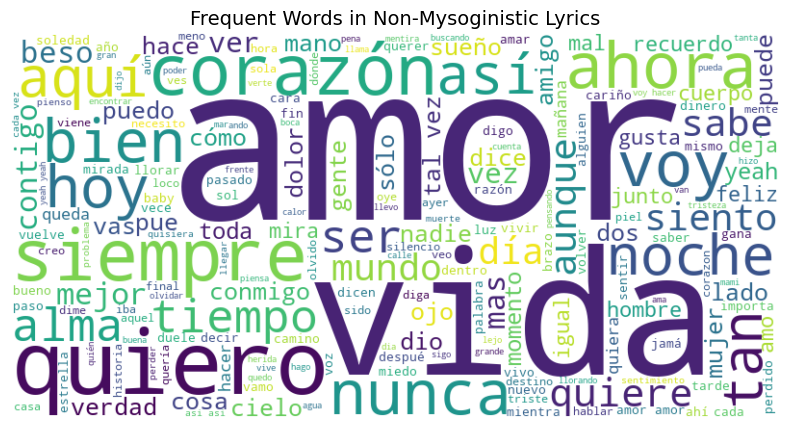

In [21]:
non_mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'NM']['lyrics'])

non_mysoginistic_lyrics_cl = text_preprocess(non_mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(non_mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Non-Mysoginistic Lyrics", fontsize=14)
plt.show()

In [22]:
# Count word frequencies
word_counts_nms = Counter(non_mysoginistic_lyrics_cl.split())
top_words_nms = word_counts_nms.most_common(10)

pd.DataFrame(top_words_nms, columns=["Word", "Frequency"])

,Word,Frequency
0,amor,2634
1,quiero,1716
2,vida,1436
3,siempre,953
4,voy,940
5,corazón,900
6,vez,871
7,ahora,816
8,nunca,802
9,ser,763


#### Frequent Words in Misogynistic Lyrics

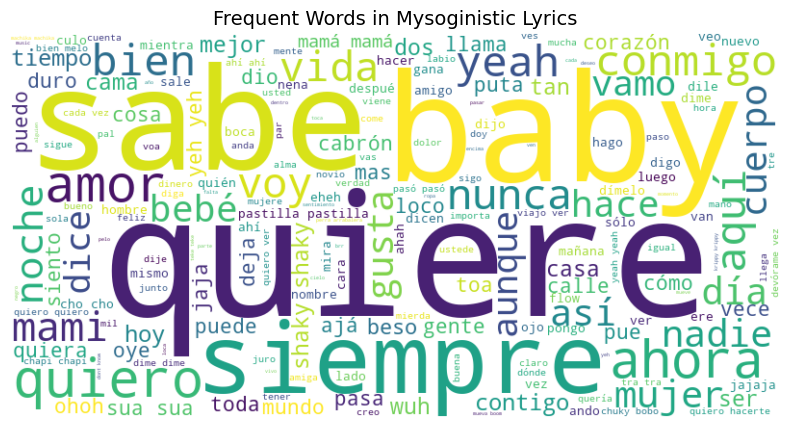

In [23]:
mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'M']['lyrics'])

mysoginistic_lyrics_cl = text_preprocess(mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Mysoginistic Lyrics", fontsize=14)
plt.show()

In [24]:
word_counts_ms = Counter(mysoginistic_lyrics_cl.split())    
top_words_ms = word_counts_ms.most_common(10)

pd.DataFrame(top_words_ms, columns=["Word", "Frequency"])

,Word,Frequency
0,quiero,1237
1,amor,737
2,baby,683
3,siempre,623
4,bien,623
5,ahora,577
6,voy,514
7,quiere,512
8,así,467
9,gusta,464


#### Word Frequency Analysis with Scattertext 

In [25]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2104 entries, T1_TRAIN_0001 to T1_TRAIN_2104
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lyrics        2104 non-null   object
 1   label         2104 non-null   object
 2   lyrics_clean  2104 non-null   object
dtypes: object(3)
memory usage: 130.3+ KB


In [ ]:
new_full_data = full_data[['lyrics_clean', 'label']].reset_index(drop=True)

nlp = spacy.load('es_dep_news_trf')

# Build corpus
corpus = st.CorpusFromPandas(
    new_full_data,
    category_col='label',
    text_col='lyrics_clean',
    nlp=nlp
).build()

# Get top 500 terms (by total frequency)
term_freq_df = corpus.get_term_freq_df()
term_freq_df['total'] = term_freq_df.sum(axis=1)
top_500_terms = term_freq_df['total'].nlargest(500).index.tolist()
# Remove all other terms from the corpus
corpus_pruned = corpus.remove_terms(set(corpus.get_terms()) - set(top_500_terms))

html = st.produce_scattertext_explorer(
    corpus_pruned,
    category='M',
    category_name='Misogynistic',
    not_category_name='Non-Misogynistic',
    width_in_pixels=1250,
    metadata=new_full_data['label']
)

# Save HTML
with open("objects\\task_1\\Images\\task1_top500_freq_terms.html", 'wb') as f:
    f.write(html.encode('utf-8'))


### Data Augmentation

### Back Translation

The next code must be executed in .py file

In [119]:
input_path = os.path.join(SUBTASK1_PATH, 'subtask1_train_rev002.csv') 

full_data = pd.read_csv(input_path, encoding='utf-8')
full_data.set_index('id', inplace=True)

output_path = os.path.join(SUBTASK1_PATH, 'subtask1_train_new_data_back_translation_complete.csv')

In [ ]:
# full_data['lyrics_pt-BR'] = full_data['lyrics'].apply(lambda x: translate(x, translator='google_official', target_lang='pt-BR', source_lang='es'))
# full_data['lyrics_spanish_pt-BR'] = full_data['lyrics_pt-BR'].apply(lambda x: translate(x, translator='google_official', target_lang='es', source_lang='pt-BR'))

full_data['lyrics_english'] = full_data['lyrics'].apply(lambda x: translate(x, translator='google_official', target_lang='en', source_lang='es'))
full_data['lyrics_spa_eng_back_trans'] = full_data['lyrics_english'].apply(lambda x: translate(x, translator='google_official', target_lang='es', source_lang='en'))

In [ ]:
full_data.to_csv(output_path, encoding='utf-8', index=True)
print(f"Saved translated data to: {output_path}")

### Synonym Replacement: Contextual Word Embeddings Augmenter

In [ ]:
synonym_folder = os.path.join(SUBTASK1_PATH, 'Synonym Replacement')
os.makedirs(synonym_folder, exist_ok=True)

aug_synon_rep_file_1 = os.path.join(
    synonym_folder,
    'subtask1_train_synonym_replacement_dccuchile_bert-base-spanish-wwm-cased.csv'
)

aug_synon_rep_file_2 = os.path.join(
    synonym_folder,
    'subtask1_train_synonym_replacement_PlanTL-GOB-ES_roberta-base-bne.csv'
)

aug_synon_rep_file_3 = os.path.join(
    synonym_folder,
    'subtask1_train_synonym_replacement_roberta-base.csv'
)


In [ ]:
input_path = os.path.join(SUBTASK1_PATH, 'subtask1_train_new_data_back_translation_complete.csv') 
full_data = pd.read_csv(input_path, encoding='utf-8')

# model_name = # 'dccuchile/bert-base-spanish-wwm-cased' # v1 spanish
model_name = 'PlanTL-GOB-ES/roberta-base-bne' # v2 spanish
# model_name = "roberta-base" # # v1 english


aug = naw.ContextualWordEmbsAug(
    model_path= model_name, 
    action="substitute",
    device='cuda' if torch.cuda.is_available() else 'cpu',
    aug_p=0.15,  # 15% of words
    top_k=10,
    #verbose=0
)

col_name = 'lyrics_augmented_{}'.format(model_name)
full_data[col_name] = full_data['lyrics'].apply(lambda x: augment_lyrics(x, aug))

full_data.to_csv(aug_synon_rep_file_2, encoding='utf-8', index=True)

In [ ]:
aug_synon_1 = pd.read_csv(aug_synon_rep_file_1, encoding='utf-8', usecols=['id', 'lyrics', 'label', 'lyrics_augmented_dccuchile/bert-base-spanish-wwm-cased'])
aug_synon_2 = pd.read_csv(aug_synon_rep_file_2, encoding='utf-8', usecols=['id', 'lyrics_augmented_PlanTL-GOB-ES/roberta-base-bne'])
aug_synon_3 = pd.read_csv(aug_synon_rep_file_3, encoding='utf-8', usecols=['id', 'lyrics_augmented_roberta-base'])

# Concatenate the DataFrames along the columns by id
file_path = 'data\subtask1_train_synonym_replacement_complete.csv'
aug_synon_combined = pd.merge(aug_synon_1, aug_synon_2, on='id', how='inner')
aug_synon_combined = pd.merge(aug_synon_combined, aug_synon_3, on='id', how='inner')
aug_synon_combined.rename(columns={'lyrics_augmented_dccuchile/bert-base-spanish-wwm-cased': 'lyrics_augmented_bert_base_spanish_wwm_cased',
                                    'lyrics_augmented_PlanTL-GOB-ES/roberta-base-bne': 'lyrics_augmented_roberta_base_bne',
                                    'lyrics_augmented_roberta-base': 'lyrics_augmented_roberta_base'}, inplace=True)

aug_synon_combined
aug_synon_combined.to_csv(file_path, encoding='utf-8', index=False)

### AEDA: An Easier Data Augmentation Technique for Text Classification

In [ ]:
file_path = os.path.join(SUBTASK1_PATH, 'subtask1_train_new_data_back_translation_complete.csv')
full_data = pd.read_csv(file_path, encoding='utf-8')

In [ ]:
random.seed(SEED)

full_data['lyrics_aeda_1'] = full_data['lyrics'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3))
full_data['lyrics_aeda_2'] = full_data['lyrics'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3))
full_data['lyrics_english_aeda_1'] = full_data['lyrics_english'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3)) 
full_data['lyrics_english_aeda_2'] = full_data['lyrics_english'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3)) 
full_data['lyrics_spanish_aeda_1'] = full_data['lyrics_spa_eng_back_trans'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3)) # Back translation data
full_data['lyrics_spanish_aeda_2'] = full_data['lyrics_spa_eng_back_trans'].apply(lambda x: insert_punctuation_marks(x, punc_ratio=0.3)) # Back translation data
augmented_aeda = full_data[['id', 'lyrics', 'lyrics_aeda_1', 'lyrics_aeda_2', 'lyrics_english_aeda_1', 'lyrics_english_aeda_2', 'lyrics_spanish_aeda_1', 'lyrics_spanish_aeda_2', 'label']].copy()
augmented_aeda

,id,lyrics,lyrics_aeda_1,lyrics_aeda_2,lyrics_english_aeda_1,lyrics_english_aeda_2,lyrics_spanish_aeda_1,lyrics_spanish_aeda_2,label
0,T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...","[Letra de ""No? Me Enseñaste""]\n\n\nLlama no im...","[Letra de? ""No Me Enseñaste""]\n\n\nLlama? no i...",Call no matter what time I'm here\nWithin the ...,"Call no matter what? time I'm here\nWithin, th...",Llamo sin importar la hora que esté aquí\nEntr...,Llamo sin importar! la hora que? esté aquí\nEn...,NM
1,T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...","Pachin!\n\nViajera, te' vas? de puerta en puer...","Pachin!\n\nViajera, te vas! de puerta! en puer...","Pachin! Traveler, you go' from door to door\nL...","Pachin! Traveler,. you go from door? to door\n...","¡Pachín!? Viajero, vas de puerta en puerta\nBu...","¡Pachín! Viajero, vas de! puerta en! puerta\nB...",M
2,T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...","n\nTe amare toda la vida\nTodos los años,? los...","n\nTe amare toda la, vida\nTodos los' años, lo...","I will! love you all my life\nEvery year,. eve...","I? will, love you all my life\nEvery year, eve...","Te amaré? toda' mi vida\nCada año, cada' mes, ...","Te amaré' toda mi vida\nCada? año, cada mes, c...",NM
3,T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...","[Letra? de ""Mi lado Oscuro"" ft. Hijo Pródigo]\...","[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...","Flower of life,. flower of life, flower of lif...","Flower of life, flower of life, flower of life...","Flor de la vida,? flor de la? vida, flor de la...","Flor de la vida, flor de la vida, flor de la v...",M
4,T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...","ba-baby\nMuah,. jajaja\n[Letra de ""Me, Enamore...","ba-baby\nMuah, jajaja\n[Letra' de, ""Me, Enamor...","ba-baby\nMuah, hahaha\nI want you to be mine a...","ba-baby\nMuah, hahaha\nI want you to be mine a...","Be-bebé\nMuah, jajaja\nQuiero' que seas mía y ...","Be-bebé\nMuah, jajaja\nQuiero! que seas mía y'...",M
...,...,...,...,...,...,...,...,...,...
2099,T1_TRAIN_2100,"\n[Letra de ""Tal Vez""]\n\n[Verso 1]\nTal vez s...","[Letra de ""Tal Vez""]\n\n\nTal vez será que esa...","[Letra de ""Tal Vez""]\n\n\nTal vez será que esa...",Maybe that story finally has an end\nI don't k...,"Maybe that story finally has an, end\nI don't ...",Quizás esa historia por fin tenga un final\nNo...,Quizás esa historia por fin tenga un! final\nN...,NM
2100,T1_TRAIN_2101,"ebra, te muerde los pies\nÍbamos a la molienda...","ebra, te, muerde los pies\nÍbamos a la moliend...","ebra, te muerde los pies\nÍbamos a la molienda...","Snake,, it' bites your feet\nWe were going to ...","Snake, it bites your feet\nWe were going to th...","Serpiente, te muerde los pies\nÍbamos al molin...","Serpiente, te muerde! los pies\nÍbamos al moli...",NM
2101,T1_TRAIN_2102,"\nTe amo, aunque a veces te maldiga\nAunque ju...","Te amo, aunque a veces te maldiga\nAunque jueg...","Te amo,! aunque a veces te maldiga\nAunque jue...","I love! you,! even though sometimes! I curse y...","I love you, even though sometimes I curse you\...","Te' quiero, aunque a veces te maldiga\nAunque ...","Te quiero, aunque a veces te maldiga\nAunque j...",NM
2102,T1_TRAIN_2103,"\n[Letra de ""ROSAS Y ESPINAS""]\n\n[Intro]\nIt'...","[Letra de ""ROSAS Y ESPINAS""]\n\n\nIt's! music....","[Letra de ""ROSAS Y. ESPINAS""]\n\n\nIt's music ...","It's music time! You're, making me dizzy! and....",It's music time! You're making me dizzy' and t...,¡Es hora' de música! Me estás mareando y eso y...,"¡Es. hora. de música!, Me estás? mareando y es...",NM


In [ ]:
# Save the augmented DataFrame to a CSV file
augmented_aeda_file_path = os.path.join(SUBTASK1_PATH, 'subtask1_train_aeda_complete.csv')
augmented_aeda.to_csv(augmented_aeda_file_path, encoding='utf-8', index=False)
print(f"Saved augmented data to: {augmented_aeda_file_path}")

### Augmented Dataset Creation for Training: Spanish Data

In [5]:
aug_back_trans_file = f"subtask1_train_back_translation_complete.csv"
aug_back_trans_file_path = os.path.join(SUBTASK1_PATH, aug_back_trans_file)

aug_synon_rep_file = f"subtask1_train_synonym_replacement_complete.csv"
aug_synon_rep_file_path = os.path.join(SUBTASK1_PATH, aug_synon_rep_file)

aug_aeda_file = f"subtask1_train_aeda_complete.csv"
aug_aeda_file_path = os.path.join(SUBTASK1_PATH, aug_aeda_file)

original_file = f"subtask1_train_rev002.csv"
original_file_path = os.path.join(SUBTASK1_PATH, original_file)

aug_back_trans = pd.read_csv(aug_back_trans_file_path, encoding='utf-8',  usecols=['id', 'lyrics', 'label', 'lyrics_spa_eng_back_trans','lyrics_spa_port_back_trans'])
aug_synon_rep = pd.read_csv(aug_synon_rep_file_path, encoding='utf-8')
aug_aeda = pd.read_csv(aug_aeda_file_path, encoding='utf-8', usecols=['id','lyrics_aeda_1', 'lyrics_spanish_aeda_1', 'label'])
original_data = pd.read_csv(original_file_path, encoding='utf-8')

print('aug_back_trans columns: ', aug_back_trans.columns)
print('aug_synon_rep columns: ', aug_synon_rep.columns)
print('aug_aeda columns: ', aug_aeda.columns)
print('original_data columns: ', original_data.columns)

aug_back_trans columns:  Index(['id', 'lyrics', 'label', 'lyrics_spa_eng_back_trans',
       'lyrics_spa_port_back_trans'],
      dtype='object')
aug_synon_rep columns:  Index(['id', 'lyrics', 'label', 'lyrics_augmented_bert_base_spanish_wwm_cased',
       'lyrics_augmented_roberta_base_bne', 'lyrics_augmented_roberta_base'],
      dtype='object')
aug_aeda columns:  Index(['id', 'lyrics_aeda_1', 'lyrics_spanish_aeda_1', 'label'], dtype='object')
original_data columns:  Index(['id', 'lyrics', 'label'], dtype='object')


##### **Option 1: Generate a balanced data set. Includes only original, back-translated, and synonym databases (legacy code)**

In [ ]:
def balance_dataset(original_data, aug_back_trans, aug_synon_rep):
    np.random.seed(SEED)
    
    # Get counts per label from the original data
    label_counts = original_data['label'].value_counts()
    majority_count = label_counts.max()
    
    augmented_list = []  # To hold augmented rows per label

    # For each label, if count < majority_count, determine how many augmented rows to add
    for label, count in label_counts.items():
        deficit = majority_count - count
        if deficit <= 0:
            continue  # No augmentation needed for this label

        # Filter the augmented datasets for the current label
        back_data = aug_back_trans[aug_back_trans['label'] == label].copy()
        synon_data = aug_synon_rep[aug_synon_rep['label'] == label].copy()
        
        # Try to fulfill the deficit from back-translation first
        n_back = len(back_data)
        if n_back >= deficit:
            sampled_back = back_data.sample(n=deficit, random_state=SEED)
        else:
            sampled_back = back_data.copy()
        
        # Create augmented rows
        if not sampled_back.empty:
            sampled_back = sampled_back.assign(
                lyrics = lambda df: df['lyrics_spa_eng_back_trans'],
                is_augmented = True,
                augmentation_type = 'back_translation'
            )[["id", "lyrics", "label", "is_augmented", "augmentation_type"]]
        
        # Calculate how many more rows we need after back_data
        remainder = deficit - len(sampled_back) if not sampled_back.empty else deficit
        
        if remainder > 0:
            # Sample the remaining rows from the synonym replacement data
            if len(synon_data) > 0:
                n_synon = min(remainder, len(synon_data))
                sampled_synon = synon_data.sample(n=n_synon, random_state=SEED)
                sampled_synon = sampled_synon.assign(
                    lyrics = lambda df: df['lyrics_augmented_bert_base_spanish_wwm_cased'],
                    is_augmented = True,
                    augmentation_type = 'synonym_replacement'
                )[["id", "lyrics", "label", "is_augmented", "augmentation_type"]]
            else:
                sampled_synon = pd.DataFrame(columns=["id", "lyrics", "label", "is_augmented", "augmentation_type"])
        else:
            sampled_synon = pd.DataFrame(columns=["id", "lyrics", "label", "is_augmented", "augmentation_type"])
        
        # Combine augmented rows for this label
        augmented_label = pd.concat([sampled_back, sampled_synon], ignore_index=True)
        augmented_list.append(augmented_label)
    
    # Combine all augmented rows
    if augmented_list:
        aug_df = pd.concat(augmented_list, ignore_index=True)
    else:
        aug_df = pd.DataFrame(columns=["id", "lyrics", "label", "is_augmented", "augmentation_type"])
    
    # Prepare original data with proper flags
    orig_df = original_data.copy()
    orig_df['is_augmented'] = False
    orig_df['augmentation_type'] = 'original'
    orig_df = orig_df[["id", "lyrics", "label", "is_augmented", "augmentation_type"]]
    
    # Final balanced dataset is the combination of original and augmented data
    final_df = pd.concat([orig_df, aug_df], ignore_index=True)
    
    return final_df


balanced_df = balance_dataset(original_data, aug_back_trans, aug_synon_rep)
balanced_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2924 non-null   object
 1   lyrics             2924 non-null   object
 2   label              2924 non-null   object
 3   is_augmented       2924 non-null   bool  
 4   augmentation_type  2924 non-null   object
dtypes: bool(1), object(4)
memory usage: 94.4+ KB


In [ ]:
file_path_balanced = os.path.join(SUBTASK1_PATH, 'subtask1_balanced_aug.csv')
balanced_df.to_csv(file_path_balanced, encoding='utf-8', index=False)
print("Balanced dataset saved to {}".format(file_path_balanced))

Now lets clean the balanced augmented dataset

In [ ]:
balanced_file_path = os.path.join(SUBTASK1_PATH, 'subtask1_balanced_aug.csv')
balanced_df = pd.read_csv(balanced_file_path, encoding='utf-8')

language = 'spa'
model_type = 'dl'
stemming = False
lemmatization = False
remove_duplicates = True
cased = True # Keep cased for DL models
return_str = True

file_name = f"subtask1_balanced_aug_lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}.csv"
file_path = os.path.join(SUBTASK1_PATH, file_name)
vocabulary = 'lyrics'

# Check if file exists otherwise preprocess and save
if os.path.exists(file_path):
    balanced_df = pd.read_csv(file_path, encoding='utf-8', index_col='id')
    print(f"File exists: {file_path}")
else:
    balanced_df['lyrics_clean'] = balanced_df[vocabulary].apply(
        lambda x: text_preprocess(
            x,
            lang=language,
            model_type=model_type,
            stem=stemming,
            lemmatize=lemmatization,
            remove_duplicates=remove_duplicates,
            cased=cased,
            return_str=return_str
        )
    )
    balanced_df.to_csv(file_path, encoding='utf-8', index=False)
    print(f"Saved cleaned data to: {file_path}")

##### **Option 2: Generate a complete dataset with all (almost) augmented data we have in Spanish**

In [7]:
back_data = aug_back_trans[['id', 'label', 'lyrics_spa_eng_back_trans']].rename(columns={'lyrics_spa_eng_back_trans': 'lyrics'})
back_data['augmentation_type'] = 'back_translation'
back_data['is_augmented'] = True

back_data_2 = aug_back_trans[['id', 'label', 'lyrics_spa_port_back_trans']].rename(columns={'lyrics_spa_port_back_trans': 'lyrics'})
back_data_2['augmentation_type'] = 'back_translation_2'
back_data_2['is_augmented'] = True

synon_data = aug_synon_rep[['id', 'label', 'lyrics_augmented_bert_base_spanish_wwm_cased']].rename(columns={'lyrics_augmented_bert_base_spanish_wwm_cased': 'lyrics'})
synon_data['augmentation_type'] = 'synonym_replacement'
synon_data['is_augmented'] = True

aeda_1_data = aug_aeda[['id', 'label', 'lyrics_aeda_1']].rename(columns={'lyrics_aeda_1': 'lyrics'})
aeda_1_data['augmentation_type'] = 'aeda_1'
aeda_1_data['is_augmented'] = True

aeda_2_data = aug_aeda[['id', 'label', 'lyrics_spanish_aeda_1']].rename(columns={'lyrics_spanish_aeda_1': 'lyrics'})
aeda_2_data['augmentation_type'] = 'aeda_2'
aeda_2_data['is_augmented'] = True

original_data['augmentation_type'] = 'original'
original_data['is_augmented'] = False

all_aug_data = pd.concat([
    original_data,
    back_data,
    back_data_2,
    synon_data,
    aeda_1_data,
    aeda_2_data,
], ignore_index=True)

all_aug_data

,id,lyrics,label,augmentation_type,is_augmented
0,T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",NM,original,False
1,T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...",M,original,False
2,T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",NM,original,False
3,T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...",M,original,False
4,T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...",M,original,False
...,...,...,...,...,...
12619,T1_TRAIN_2100,Quizás esa historia por fin tenga un final\nNo...,NM,aeda_2,True
12620,T1_TRAIN_2101,"Serpiente, te muerde los pies\nÍbamos al molin...",NM,aeda_2,True
12621,T1_TRAIN_2102,"Te' quiero, aunque a veces te maldiga\nAunque ...",NM,aeda_2,True
12622,T1_TRAIN_2103,¡Es hora' de música! Me estás mareando y eso y...,NM,aeda_2,True


In [8]:
all_aug_data['augmentation_type'].value_counts()

augmentation_type
original               2104
back_translation       2104
back_translation_2     2104
synonym_replacement    2104
aeda_1                 2104
aeda_2                 2104
Name: count, dtype: int64

In [ ]:
language = 'spa'
model_type = 'dl'
stemming = False
lemmatization = False
remove_duplicates = False
cased = True # Keep cased for DL models
return_str = True

file_name = f"subtask1_all_aug_lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}.csv"

file_path = os.path.join(SUBTASK1_PATH, file_name)
vocabulary = 'lyrics'

# Check if file exists, otherwise preprocess and save
if os.path.exists(file_path):
    all_aug_data = pd.read_csv(file_path, encoding='utf-8', index_col='id')
    print(f"File exists: {file_path}")
else:
    # Apply preprocessing
    all_aug_data['lyrics_clean'] = all_aug_data[vocabulary].apply(
        lambda x: text_preprocess(
            x,
            lang=language,
            model_type=model_type,
            stem=stemming,
            lemmatize=lemmatization,
            remove_duplicates=remove_duplicates,
            cased=cased,
            return_str=return_str
        )
    )
    all_aug_data.to_csv(file_path, encoding='utf-8', index=False)
    print(f"Saved cleaned data to: {file_path}")

File exists: new_data\subtask1\subtask1_all_aug_lang_spa_model_dl_stem_False_lem_False_dup_False_cased_True.csv


In [11]:
all_aug_data

,lyrics,label,augmentation_type,is_augmented,lyrics_clean
id,,,,,
T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",NM,original,False,"[Letra de ""No Me Enseñaste""]\nLlama no importa..."
T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...",M,original,False,"Pachin!\nViajera, te vas de puerta en puerta\n..."
T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",NM,original,False,"Te amare toda la vida\nTodos los años, los mes..."
T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...",M,original,False,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n..."
T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...",M,original,False,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D..."
...,...,...,...,...,...
T1_TRAIN_2100,Quizás esa historia por fin tenga un final\nNo...,NM,aeda_2,True,Quizás esa historia por fin tenga un final\nNo...
T1_TRAIN_2101,"Serpiente, te muerde los pies\nÍbamos al molin...",NM,aeda_2,True,"Serpiente, te muerde los pies\nÍbamos al molin..."
T1_TRAIN_2102,"Te' quiero, aunque a veces te maldiga\nAunque ...",NM,aeda_2,True,"Te' quiero, aunque a veces te maldiga\nAunque ..."


##### **Option 3: Generate a balanced dataset with augmented data by back-translation and AEDA**

In [38]:
aug_aeda_file = f"subtask1_train_aeda_complete.csv"
aug_aeda_file_path = os.path.join(SUBTASK1_PATH, aug_aeda_file)

original_file = f"subtask1_train_rev002.csv"
original_file_path = os.path.join(SUBTASK1_PATH, original_file)

aug_back_trans_file = f"subtask1_train_back_translation_complete.csv"
aug_back_trans_file_path = os.path.join(SUBTASK1_PATH, aug_back_trans_file)

aug_back_trans = pd.read_csv(aug_back_trans_file_path, encoding='utf-8') 
aug_aeda = pd.read_csv(aug_aeda_file_path, encoding='utf-8', usecols=['id','lyrics_aeda_1', 'label'])
original_data = pd.read_csv(original_file_path, encoding='utf-8')

In [41]:
# Spanisgh-English back translation
back_data_1 = aug_back_trans[['id', 'label', 'lyrics_spa_eng_back_trans']].rename(columns={'lyrics_spa_eng_back_trans': 'lyrics'})
back_data_1['augmentation_type'] = 'back_translation'
back_data_1['is_augmented'] = True

# Spanish-Portuguese back translation
back_data_2 = aug_back_trans[['id', 'label', 'lyrics_spa_port_back_trans']].rename(columns={'lyrics_spa_port_back_trans': 'lyrics'}) 
back_data_2['augmentation_type'] = 'back_translation'
back_data_2['is_augmented'] = True

# AEDA on original lyrics .30
aeda_data = aug_aeda[['id', 'label', 'lyrics_aeda_1']].rename(columns={'lyrics_aeda_1': 'lyrics'})
aeda_data['augmentation_type'] = 'aeda_1'
aeda_data['is_augmented'] = True

original_data['augmentation_type'] = 'original'
original_data['is_augmented'] = False

# Concatenate all DataFrames vertically
all_aug_data = pd.concat([
    original_data,
    back_data_1,
    back_data_2,
    aeda_data,
], ignore_index=True)

all_aug_data['label'].value_counts()

label
NM    5848
M     2568
Name: count, dtype: int64

In [42]:
all_aug_data[all_aug_data['id']=='T1_TRAIN_1324']

,id,lyrics,label,augmentation_type,is_augmented
1323,T1_TRAIN_1324,"mierda pura, fuck\n[Letra de ""Marca de la Cad...",NM,original,False
3427,T1_TRAIN_1324,"Pura mierda, carajo\nNo son tatuajes en mi cue...",NM,back_translation,True
5531,T1_TRAIN_1324,"pura mierda, joder\n[Letra de ""Marca de la Cad...",NM,back_translation,True
7635,T1_TRAIN_1324,"mierda pura, fuck\n[Letra de ""Marca' de la Cad...",NM,aeda_1,True


In [43]:
def create_balanced_dataset(all_aug_data):
    # Calculate target_count as the total number of samples in the minority class
    target_count = all_aug_data['label'].value_counts().min()
    print(f"Target count for each class: {target_count} \n")

    balanced_list = []

    # Process each class separately
    for label, group in all_aug_data.groupby('label'):
        # All original samples for this class
        original = group[group['is_augmented'] == False]
        print(f"Original samples for {label}: {len(original)}")
        # All original samples for this class
        # All augmented samples for this class
        augmented = group[group['is_augmented'] == True]
        print(f"Augmented samples for {label}: {len(augmented)}")
        
        # If original samples already exceed target_count, downsample them
        if len(original) >= target_count:
            combined = original.sample(n=target_count, random_state=SEED)
        else:
            # Otherwise, keep all original data
            n_original = len(original)
            # Determine how many augmented samples are needed to reach the target_count
            n_aug_needed = target_count - n_original
            print(f"Augmented samples needed for {label}: {n_aug_needed}")
            
            # If there are not enough augmented samples, take all; else sample n_aug_needed
            print(f"n_aug_needed > len(augmented): {n_aug_needed > len(augmented)}")
            if n_aug_needed > len(augmented):
                sampled_aug = augmented
            else:
                sampled_aug = augmented.sample(n=n_aug_needed, random_state=SEED)
                print(f"Sampled augmented samples for {label}: {len(sampled_aug)}\n")
            
            # Concatenate originals with the sampled augmented data
            combined = pd.concat([original, sampled_aug], ignore_index=True)
        
        balanced_list.append(combined)

    # Combine all classes into a final balanced dataset
    balanced_dataset = pd.concat(balanced_list, ignore_index=True)

    # Verify the balance across classes
    print(balanced_dataset['label'].value_counts())
    return balanced_dataset

In [44]:
balanced_dataset = create_balanced_dataset(all_aug_data)

Target count for each class: 2568 

Original samples for M: 642
Augmented samples for M: 1926
Augmented samples needed for M: 1926
n_aug_needed > len(augmented): False
Sampled augmented samples for M: 1926

Original samples for NM: 1462
Augmented samples for NM: 4386
Augmented samples needed for NM: 1106
n_aug_needed > len(augmented): False
Sampled augmented samples for NM: 1106

label
M     2568
NM    2568
Name: count, dtype: int64


In [47]:
file_path_balanced = 'subtask1_balanced_aug_v2.csv'

balanced_dataset.to_csv(os.path.join(SUBTASK1_PATH, file_path_balanced), encoding='utf-8', index=False)
print("Balanced dataset saved to {}".format(file_path_balanced))

Balanced dataset saved to subtask1_balanced_aug_v2.csv


Cleaning the balanced dataset

In [48]:
balanced_file = f"subtask1_balanced_aug_v2.csv"
balanced_file_path = os.path.join(SUBTASK1_PATH, balanced_file)
balanced_df = pd.read_csv(balanced_file_path, encoding='utf-8')

language = 'spa'
model_type = 'dl'
stemming = False
lemmatization = False
remove_duplicates = True
cased = True # Keep cased for DL models
return_str = True

file_name = f"subtask1_balanced_aug_v2_lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}.csv"
file_path = os.path.join(SUBTASK1_PATH, file_name)
vocabulary = 'lyrics'

# Check if file exists otherwise preprocess and save
if os.path.exists(file_path):
    balanced_df = pd.read_csv(file_path, encoding='utf-8', index_col='id')
    print(f"File exists: {file_path}")
else:
    balanced_df['lyrics_clean'] = balanced_df[vocabulary].apply(
        lambda x: text_preprocess(
            x,
            lang=language,
            model_type=model_type,
            stem=stemming,
            lemmatize=lemmatization,
            remove_duplicates=remove_duplicates,
            cased=cased,
            return_str=return_str
        )
    )
    balanced_df.to_csv(file_path, encoding='utf-8', index=False)
    print(f"Saved cleaned data to: {file_path}")

Saved cleaned data to: new_data\subtask1\subtask1_balanced_aug_v2_lang_spa_model_dl_stem_False_lem_False_dup_True_cased_True.csv


In [49]:
balanced_df.set_index('id', inplace=True)
balanced_df[
    (balanced_df['is_augmented'] == True) & 
    (balanced_df['label'] == 'NM')
].groupby('augmentation_type')['lyrics'] \
 .apply(len) \
 .reset_index(name='count')


,augmentation_type,count
0,aeda_1,356
1,back_translation,750


In [51]:
# balanced_df.loc['T1_TRAIN_0720']
balanced_df.loc['T1_TRAIN_0237']

,lyrics,label,augmentation_type,is_augmented,lyrics_clean
id,,,,,
T1_TRAIN_0237,ítate que masturbas)\n[Verse 1]\nWhen you told...,M,original,False,ítate que masturbas)\nWhen you told me that it...
T1_TRAIN_0237,"(Adelante, te masturbas)\nCuando me dijiste qu...",M,back_translation,True,"(Adelante, te masturbas)\nCuando me dijiste qu..."
T1_TRAIN_0237,Te dije que te masturbabas)\nCuando me dijiste...,M,back_translation,True,Te dije que te masturbabas)\nCuando me dijiste...
T1_TRAIN_0237,ítate que masturbas)\n\nWhen you told me that ...,M,aeda_1,True,ítate que masturbas)\nWhen you told me that it...
